# Leap-frog discretization of the wave equation

In this notebook, we consider the "leap-frog" discretization of the scalar wave equation
$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} \Longleftrightarrow
\frac{\partial}{\partial t} \begin{pmatrix} u \\ v \end{pmatrix} =
c\frac{\partial}{\partial x} \begin{pmatrix} v \\ u \end{pmatrix}
$$
with **periodic boundary conditions** on a domain $\Omega = [0,L]$.  The reason that we want periodic boundary
conditions is that we want to look at d'Alembert-like *travelling solutions*
$$
u(x,t) = f(x \pm ct) \Longleftrightarrow \begin{pmatrix} u \\ v \end{pmatrix} = \begin{pmatrix} f(x \pm ct) \\ \pm f(x \pm ct) \end{pmatrix}
$$
and periodic boundaries allow the wave to exit the computational cell at the right and re-enter it at the left (or vice versa).

Recall that the leap-frog discretization uses a *staggered* grid.  If we discretize time as $t = n\Delta t$ and $x = m\Delta x$, then we discretize $u$ via $u^n_m$ but $v$ by $v^{n+0.5}_{m+0.5}$, offset by half in both space and time.  This allows us to use the centered-difference discretization:
$$
v^{n+0.5}_{m+0.5} = v^{n-0.5}_{m+0.5} + \frac{c \Delta t}{\Delta x} \left( u^n_{m+1} - u^n_m  \right) \\
u^{n+1}_m = u^n_m + \frac{c \Delta t}{\Delta x} \left( v^{n+0.5}_{m+0.5} - v^{n+0.5}_{m-0.5}  \right)
$$
From von-Neumann analysis, we must have $c \Delta t / \Delta x < 1$ for stability.

We will discretize the domain $[0,L]$ into $M$ points with $\Delta x = L/M$ and periodicity $u_m = u_{m+M}$.   In Julia, we will store $u^n_m$ in an array `u[m]` for `m=1:M`, and $v^{n-0.5}_{m+0.5}$ in an array `v[m]`.   Then we can timestep by updating first `v` and then `u`, with a function we'll call `timestep!`:

In [1]:
"""
    timestep!(u,v, cdtdx=0.9)

Given `v` at some timestep n-0.5 and `u` at timestep n, update `u` and `v`
*in-place* to timesteps n+0.5 and n+1, respectively, via a leapfrog scheme
for a 1d wave equation with periodic boundary conditions.

The parameter `cdtdx` equals cΔt/Δx, and should be `< 1` for
stability.
"""
function timestep!(u,v, cdtdx=0.9)
    M = length(u)
    assert(length(v) == M)
    for m = 1:M-1
        v[m] += cdtdx * (u[m+1] - u[m])
    end
    v[M] += cdtdx * (u[1] - u[M])
    for m = 2:M
        u[m] += cdtdx * (v[m] - v[m-1])
    end
    u[1] += cdtdx * (v[1] - v[M])
    return (u,v)
end

"""
As above, but timestep `n` times.
"""
function timestep!(n::Integer, u,v, cdtdx=0.9)
    for i = 1:n
        timestep!(u,v, cdtdx)
    end
    return (u,v)
end

timestep! (generic function with 4 methods)

In [2]:
using PyPlot

Now, let's set up some basic parameters of the simulation:

In [3]:
L = 10
M = 1000
Δx = L / M
cdtdx = 0.9
cΔt = cdtdx * Δx
x = (1:M)*Δx

0.01:0.01:10.0

## Initial conditions

We want to excite the **right-travelling** solution
$$
u(x,t) = f(x - ct) \Longleftrightarrow \begin{pmatrix} u \\ v \end{pmatrix} = \begin{pmatrix} f(x - ct) \\ - f(x - ct) \end{pmatrix}
$$
for some $f(x)$.  Our initial condition, at $t=0$, would therefore seem to be $u(x,0) = f(x)$ and $v(x,0) = -f(x)$.  However, we have to be careful of the discretization: if `u` is $u(m\Delta x,0)$, the array `v` is actually $v([m+0.5]\Delta x, -0.5 \Delta t)$.

We'll use a nicely localized Gaussian $f(x) = e^{-(x-L/2)^2 / 2\sigma^2}$ shape, with a small width $\sigma$:

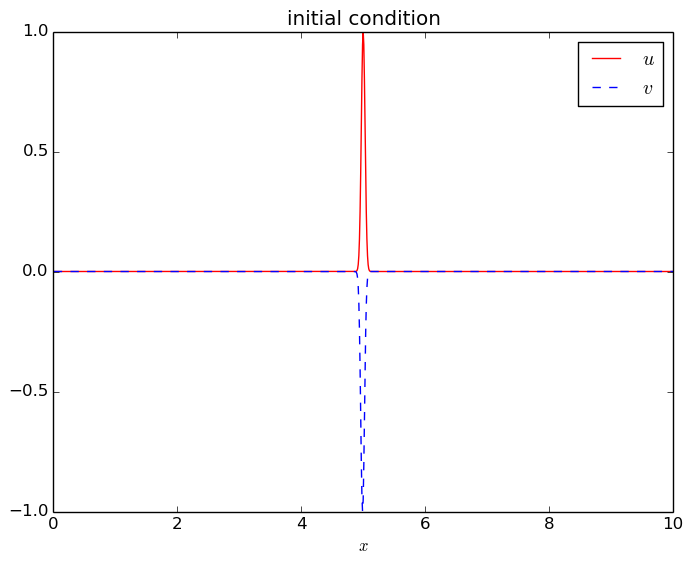

PyObject <matplotlib.text.Text object at 0x7f16a3270510>

In [4]:
σ = 0.03
f(x) = exp(-0.5 * (x-L/2)^2 / σ^2)
# f(x) = max(0, 1 - abs((x - L/2) * 10/L))

u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ -f((m+0.5)*Δx + 0.5*cΔt) for m in 1:M];

plot(x, u, "r-")
plot(x, v, "b--")
legend([L"u", L"v"])
xlabel(L"x")
title("initial condition")

We can plot it for a few time steps to verify that it is travelling to the right as desired:

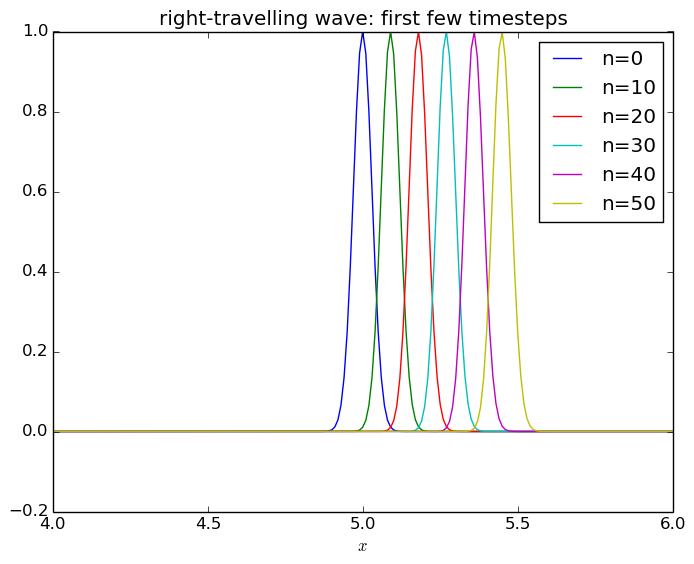

PyObject <matplotlib.text.Text object at 0x7f16a2f47b50>

In [5]:
u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ -f((m+0.5)*Δx + 0.5*cΔt) for m in 1:M];
plot(x, u)
xlim(4, 6)
for i = 1:5
    timestep!(10, u,v,cdtdx)
    plot(x, u)
end
legend(["n=$(10i)" for i in 0:5])
xlabel(L"x")
title("right-travelling wave: first few timesteps")

If, instead, we set the initial $v$ to **zero**, then this corresponds to a *superposition of left-and-right traveling waves* (the sum of the $\pm$ solutions).  After a few timesteps, the two solutions separate:

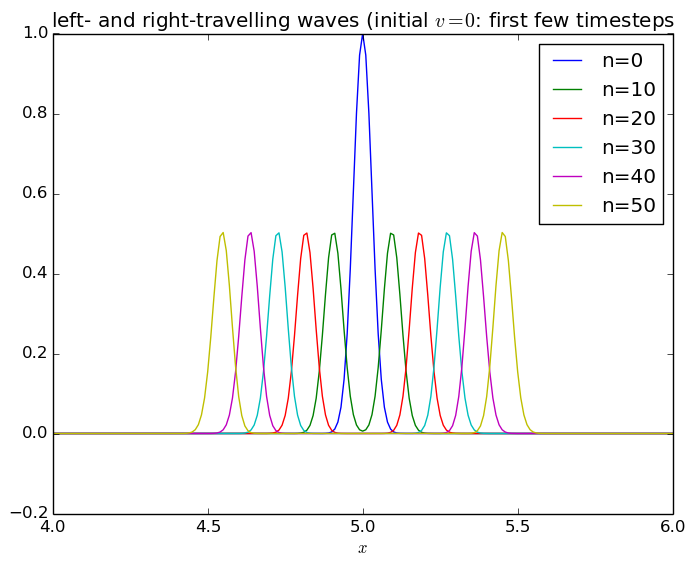

PyObject <matplotlib.text.Text object at 0x7f16a2ef7f90>

In [6]:
u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ 0 for m in 1:M];
plot(x, u)
xlim(4, 6)
for i = 1:5
    timestep!(10, u,v,cdtdx)
    plot(x, u)
end
legend(["n=$(10i)" for i in 0:5])
xlabel(L"x")
title("left- and right-travelling waves (initial \$v=0\$: first few timesteps")

## Stability

Recall that we require $c \Delta t / \Delta x < 1$ for stability.   If we make this ratio even slightly larger than 1, e.g. 1.006, we find that the solution quickly blows up, and the $u_m \sim e^{i\pi m} = (-1)^m$ solution is the one that blows up first in accordance with von-Neumann analysis:

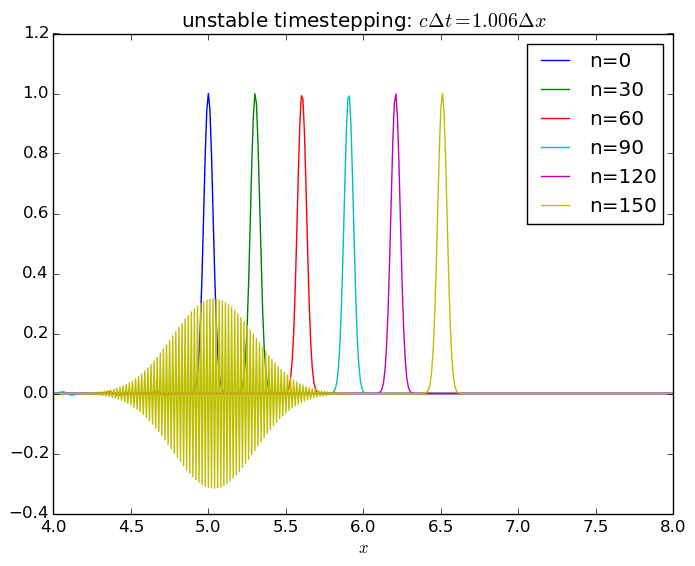

PyObject <matplotlib.text.Text object at 0x7f16a2bb5b50>

In [7]:
u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ -f((m+0.5)*Δx + 0.5*cΔt) for m in 1:M];
plot(x, u)
xlim(4, 8)
for i = 1:5
    timestep!(30, u,v, 1.006)
    plot(x, u)
end
legend(["n=$(30i)" for i in 0:6])
xlabel(L"x")
title("unstable timestepping: \$ c\\Delta t = 1.006 \\Delta x\$")

## Numerical dispersion

If we run the simulation for a long time, we will see that, unlike the analytical d'Alembert solution, our solution actually changes shape as it propagates.   The pulse spreads out, and the *low frequencies travel faster than the high frequencies*.

(Soon, we will explain this via Fourier analysis, the dispersion relation, and group velocity.)

In [8]:
using Interact

Interact.Slider{Int64}(Signal{Int64}(1, nactions=0),"",1,1:10000,true)

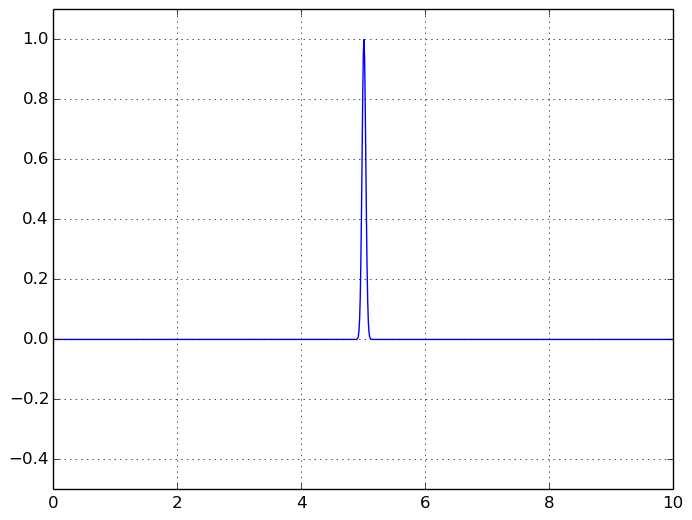

In [9]:
fig = figure()

nprev = 0
u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ -f((m+0.5)*Δx + 0.5*cΔt) for m in 1:M];
@manipulate for n in slider(1:10000, value=1)
    withfig(fig) do
        global nprev
        if n > nprev
            timestep!(n - nprev, u,v,cdtdx)
            nprev = n
        end
        plot(x, u)
        ylim(-0.5, 1.1)
        xlim(0, L)
        grid()
    end
end

To allow easier comparison, let's also superimpose plots of the solution at different numbers of timesteps:

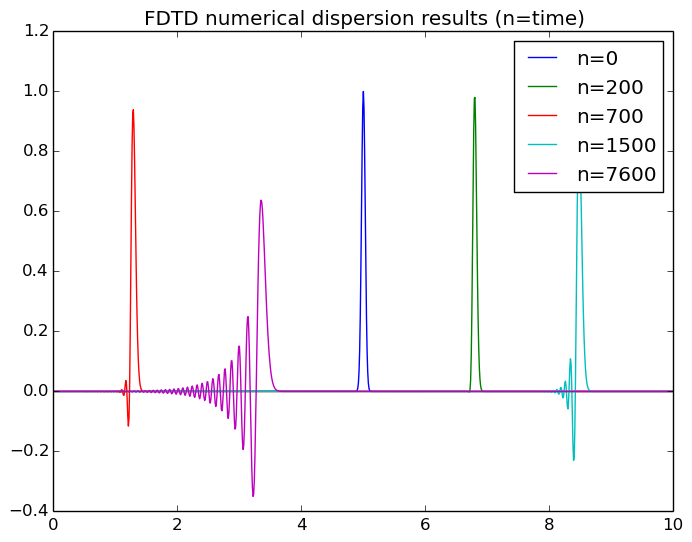

PyObject <matplotlib.text.Text object at 0x7f16a0ea8990>

In [11]:
u = Float64[ f(m*Δx) for m in 1:M]
v = Float64[ -f((m+0.5)*Δx + 0.5*cΔt) for m in 1:M];

plot(x, u)
timestep!(200, u,v, cdtdx)
plot(x, u)
timestep!(700-200, u,v, cdtdx)
plot(x, u)
timestep!(1500-700, u,v, cdtdx)
plot(x, u)
timestep!(7600-1500, u,v, cdtdx)
plot(x, u)
legend(["n=0","n=200","n=700","n=1500","n=7600"])
title("FDTD numerical dispersion results (n=time)")

The resulting pulse (here at $n=7600$ timesteps, in purple), is sometimes called a [chirped](https://en.wikipedia.org/wiki/Chirp) pulse.   If it was a sound wave, then the low frequencies would hit your ear first, followed by higher frequencies, resulting in "chirp" sound, hence the name.